# Process Rasters for Errosion Rate Calculation
This file is used to process Sentinel-2 scenes so they can be use to calculate erosion rates. The output is similar to files from 0_process_rasters.ipynb. Except:
<ul>
<li>These files do no not have a vegetation line.
<li>Both a .npy file and .tif file is saved for geolocation information
<ul>


In [1]:
import os
import glob
import numpy as np
import pandas as pd

import rasterio
from rasterio.plot import show
from rasterio.features import rasterize
from shapely.geometry import LineString
import geopandas as gpd

import matplotlib.pyplot as plt
import cv2

# reimport 
import utils 
import importlib
importlib.reload(utils)

data_path = "/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/data"

In [8]:
geolocations = np.load("../data/processed/meta/geolocations.npy", allow_pickle=True).item()
print(geolocations)

# Points dictionary
points_dict = np.load('../data/SIVE/points_dict.npy', allow_pickle=True).item()
points_dict.keys()

{'bull_island': {'left': 685005.0, 'top': 5921495.0, 'right': 695005.0, 'bottom': 5912495.0}, 'portmarnock': {'left': 687005.0, 'top': 5927495.0, 'right': 695005.0, 'bottom': 5917495.0}, 'portrane': {'left': 688505.0, 'top': 5936195.0, 'right': 695005.0, 'bottom': 5928695.0}, 'rossnowlagh': {'left': 546985.0, 'top': 6050015.0, 'right': 553985.0, 'bottom': 6042015.0}, 'tramore': {'left': 624005.0, 'top': 5783015.0, 'right': 633005.0, 'bottom': 5777015.0}}


dict_keys(['20240623T114351_tramore', '20221211T114501_rossnowlagh', '20221204T115451_rossnowlagh', '20221116T114349_rossnowlagh', '20221007T114349_rossnowlagh', '20220922T114401_rossnowlagh', '20220910T115359_rossnowlagh', '20220905T115411_rossnowlagh', '20220813T114401_rossnowlagh', '20220811T115409_rossnowlagh', '20220722T115409_rossnowlagh', '20220607T115411_rossnowlagh', '20220604T114401_rossnowlagh', '20220523T115359_rossnowlagh', '20220408T115401_rossnowlagh', '20220326T114351_rossnowlagh', '20220319T115401_rossnowlagh', '20240211T113311_portrane', '20220323T113321_portrane', '20201002T114401_portrane', '20190707T113321_portrane', '20190207T113321_portmarnock', '20171129T113419_portmarnock', '20230904T113321_bull_island', '20230604T114349_bull_island', '20230530T114351_bull_island', '20230420T114351_bull_island', '20190920T113319_bull_island', '20190826T113321_bull_island', '20190707T113321_bull_island', '20190627T113321_bull_island', '20190501T114351_bull_island', '20190411T114

In [9]:
safe_files = glob.glob(f"../data/raw/erosion/*.SAFE")
print(f"Number of files: {len(safe_files)}")

base_names = [os.path.basename(f).split(".")[0] for f in safe_files]

# Get the unique identifiers
identifiers = [f.split("_")[2] for f in base_names]

# sort base_names by identifiers in descending order
sorted_indices = np.argsort(identifiers)[::-1]
safe_files = np.array(safe_files)[sorted_indices]

Number of files: 33


In [10]:
aoi = "bull_island"
erosion_points_dict = {}

# Use the same UTM coordinates for all images in the same AOI
left = geolocations[aoi]["left"]
top = geolocations[aoi]["top"]
right = geolocations[aoi]["right"]
bottom = geolocations[aoi]["bottom"]
utm = (left, top, right, bottom)

for path in safe_files:

    filename = path.split("/")[-1]

    date = filename.split("_")[2]
    date = date[:4] + "-" + date[4:6] + "-" + date[6:8]

    ID = filename.split("_")[2]
    ID = f"{ID}_{aoi}"

    # Save AOI
    output_tif = f"../data/processed/aoi_crop/erosion/{ID}.tif"
    utils.stack_crop_resample(path, output_tif,
                                    resampling_factor=1, 
                                    utm=utm)
    
    # Append guidance band 
    with rasterio.open(output_tif) as src:
        raster = src.read()
        profile = src.profile
        transform = src.transform

    # Guidance signal
    guidance = np.load(f"../data/processed/guidance/{aoi}.npy")
    guidance = np.clip(guidance, 0, 1).astype(np.uint16)

    guidance = np.expand_dims(guidance, axis=0)

    # Add guidance and mask to raster
    raster = np.concatenate((raster, guidance), axis=0)

    # Update metadata
    profile.update({
        "count": raster.shape[0],
        "dtype": raster.dtype,
        "compress": "lzw"
    })

    # Save the output
    output_path = os.path.join(data_path, f"processed/aoi_stacked/erosion/{ID}.tif")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(raster)

    #save .npy version
    output_path = output_path.replace(".tif", ".npy")
    np.save(output_path, raster)

    #Update points_dict
    erosion_points_dict [ID] = points_dict['20190627T113321_bull_island'] # use the same points for all erosion images
    
    print(f"Saved: {output_path}")

Saved stacked Sentinel-2 bands to ../data/processed/aoi_crop/erosion/20210721T113319_bull_island.tif
Saved: /Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/data/processed/aoi_stacked/erosion/20210721T113319_bull_island.npy
Saved stacked Sentinel-2 bands to ../data/processed/aoi_crop/erosion/20210719T114351_bull_island.tif
Saved: /Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/data/processed/aoi_stacked/erosion/20210719T114351_bull_island.npy
Saved stacked Sentinel-2 bands to ../data/processed/aoi_crop/erosion/20210716T113321_bull_island.tif
Saved: /Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/data/processed/aoi_stacked/erosion/20210716T113321_bull_island.npy
Saved stacked Sentinel-2 bands to ../data/processed/aoi_crop/erosion/20210629T114351_bull_island.tif
Saved: /Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation

In [11]:
# Save the updated points_dict
np.save('../data/SIVE/erosion_points_dict.npy', erosion_points_dict )

# Sense check

In [12]:
erosion_files = glob.glob(f"../data/processed/aoi_stacked/erosion/*.tif")
# Sort files by date
erosion_files.sort()

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_45706/2820975030.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))


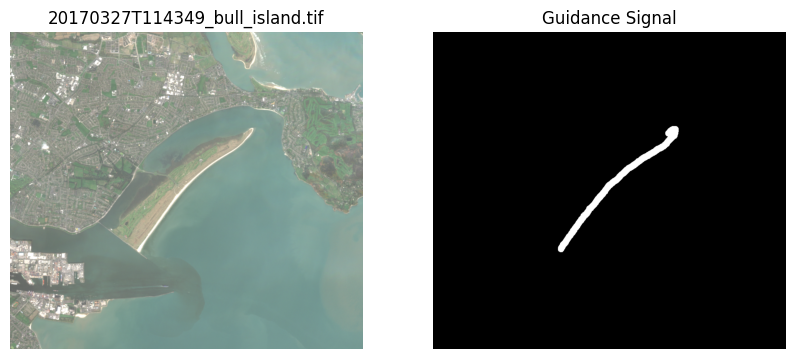

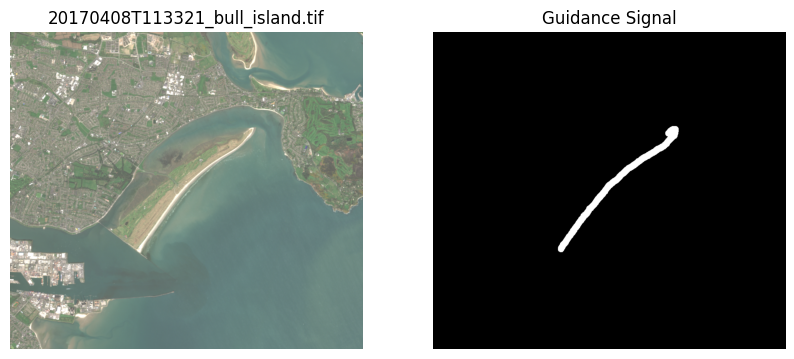

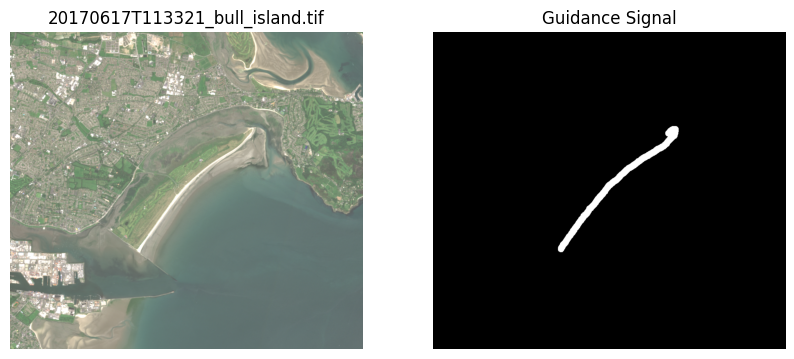

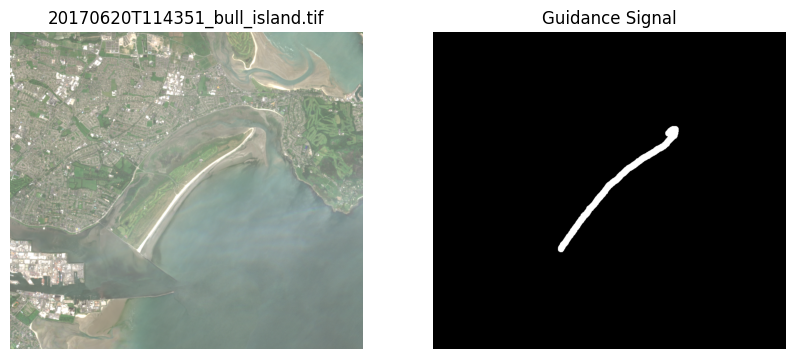

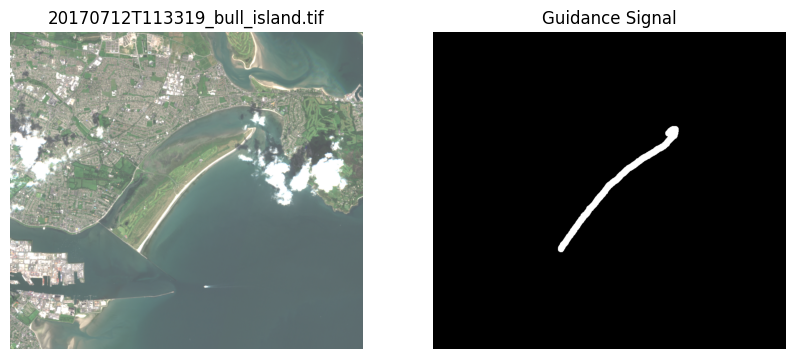

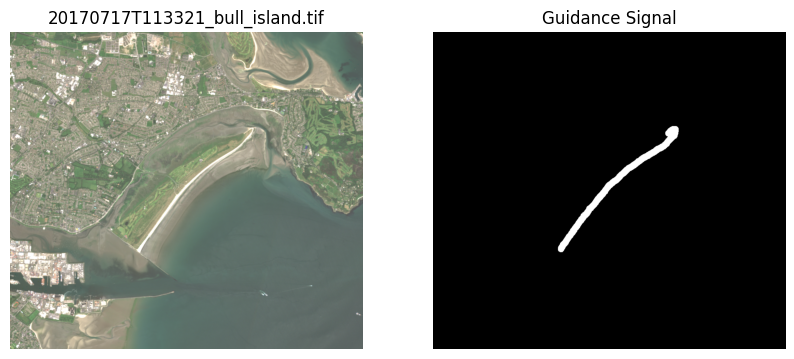

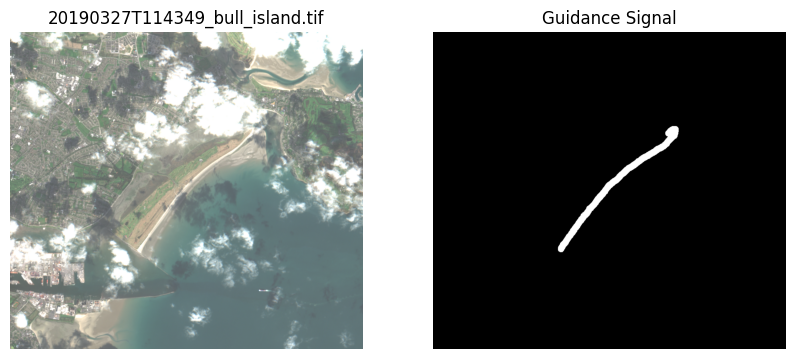

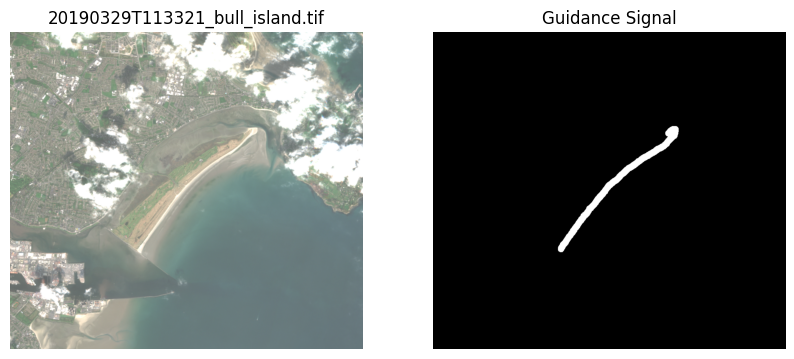

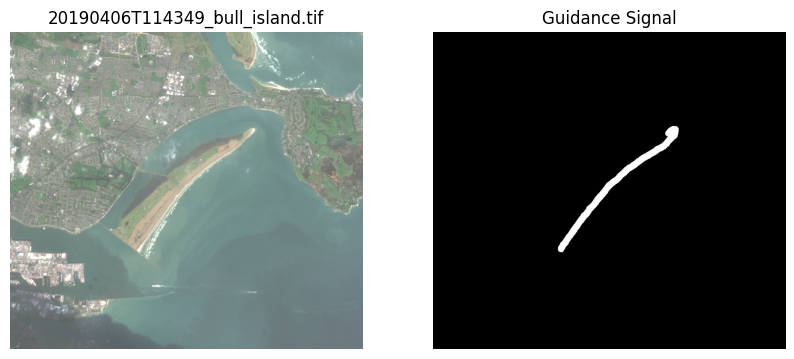

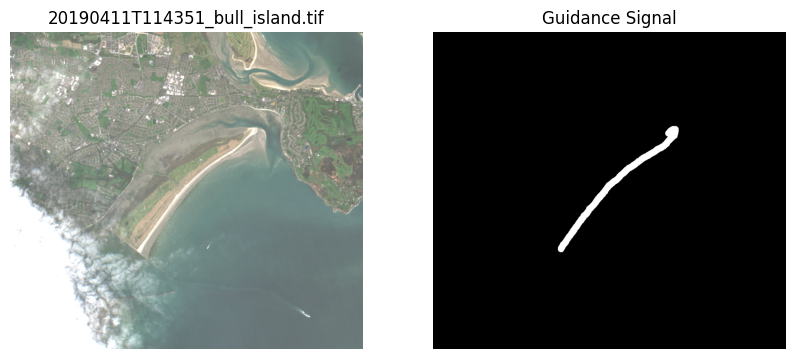

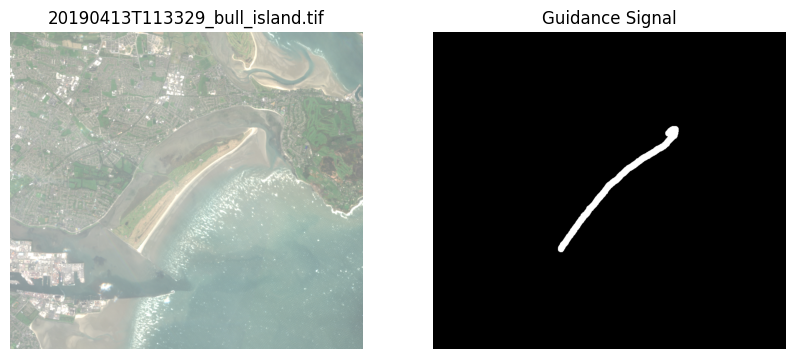

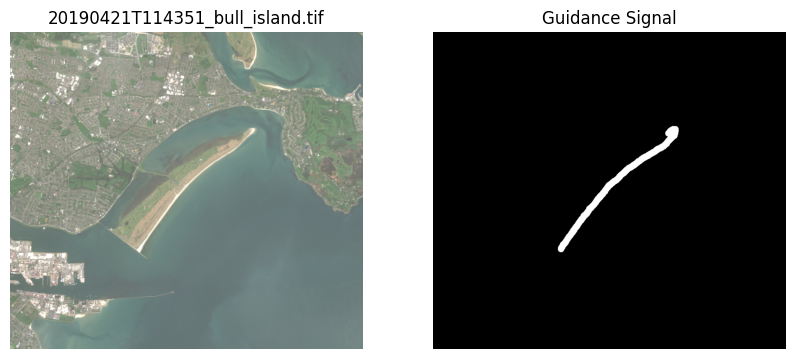

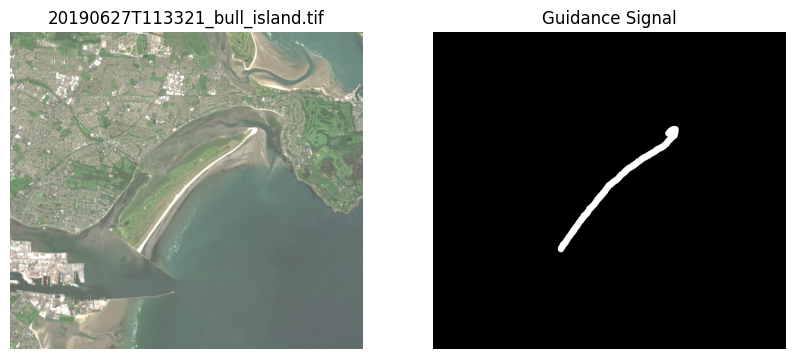

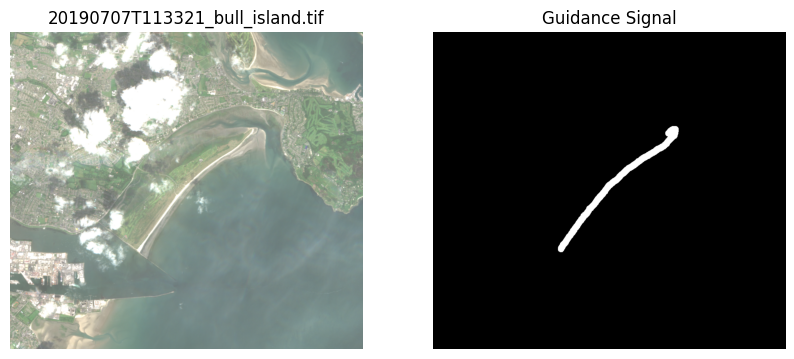

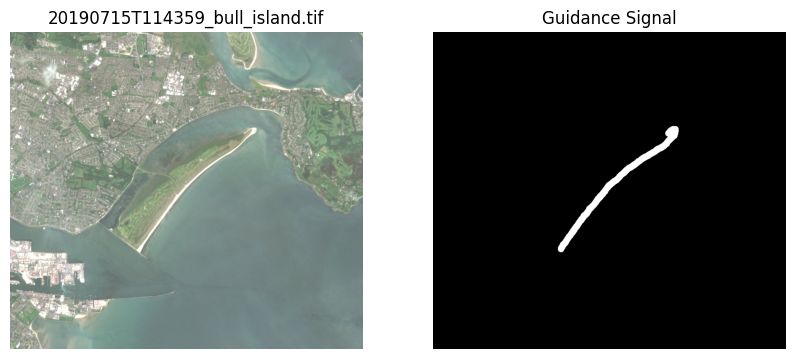

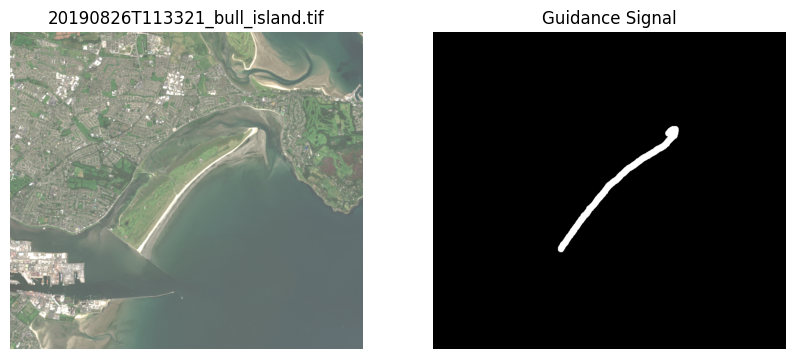

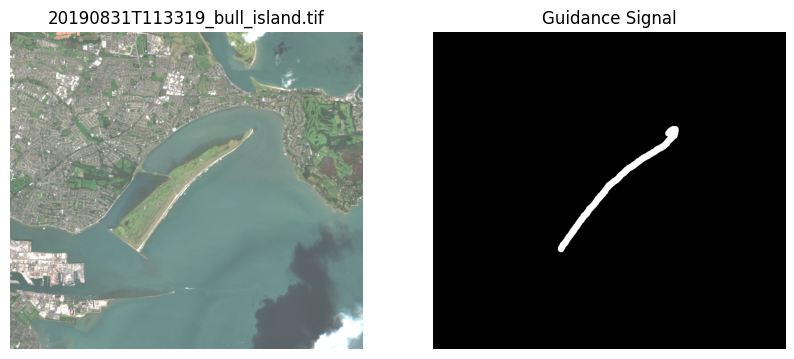

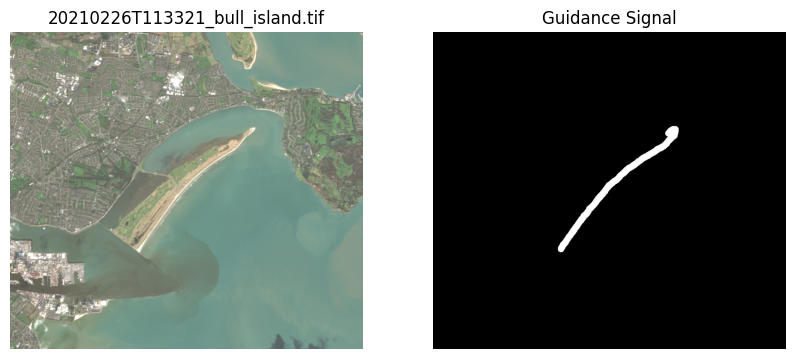

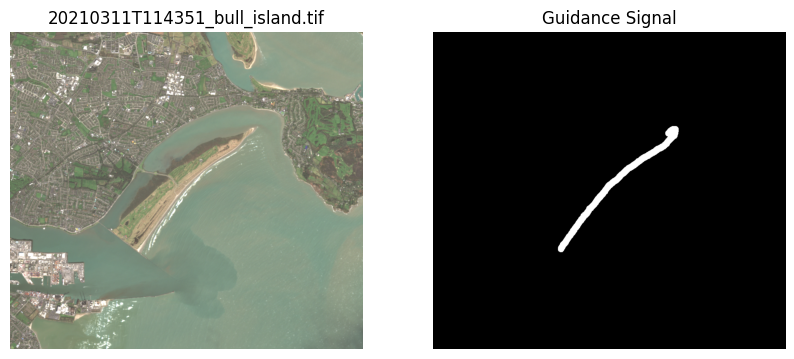

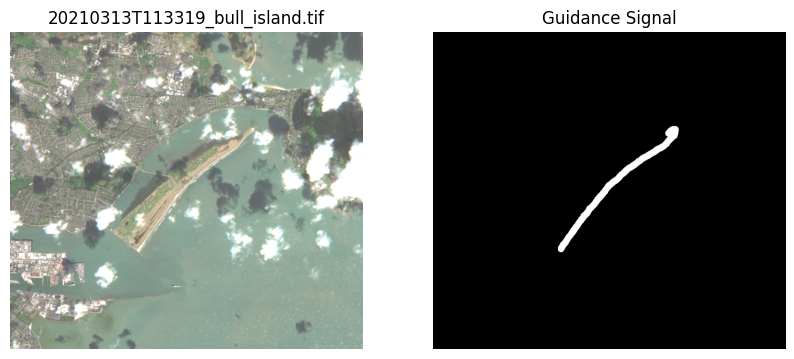

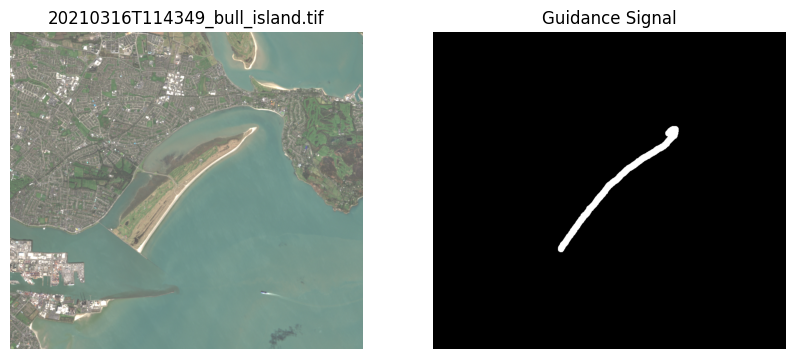

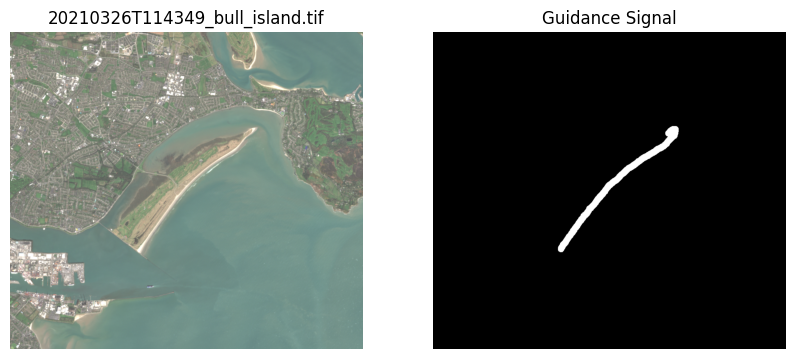

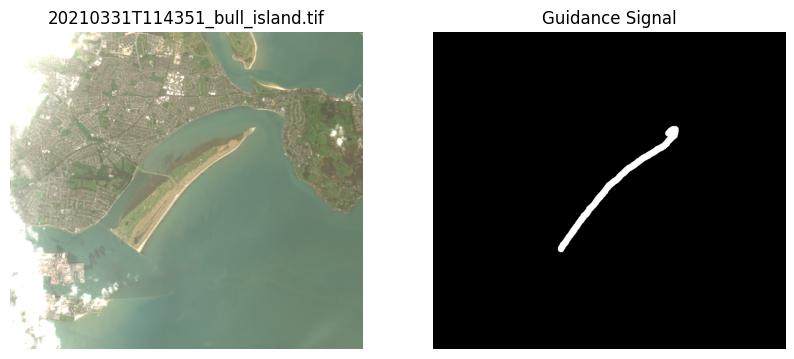

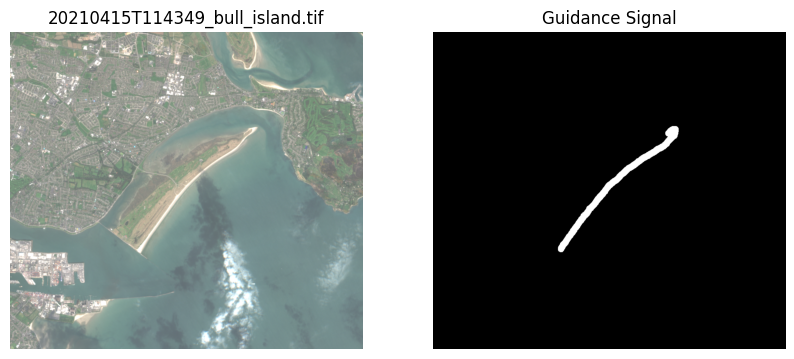

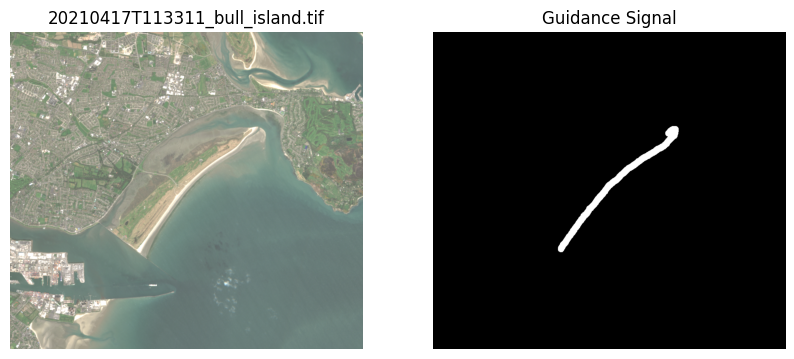

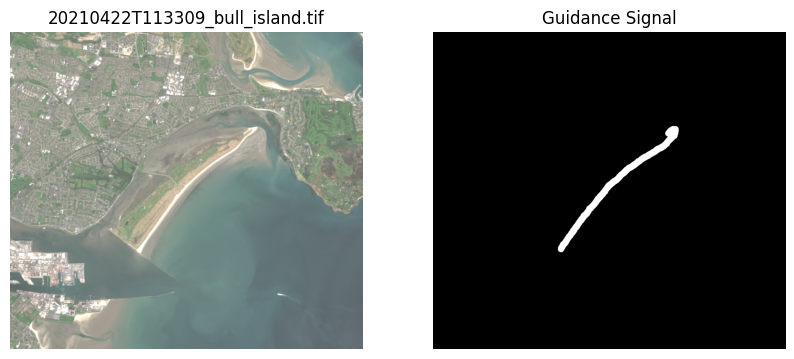

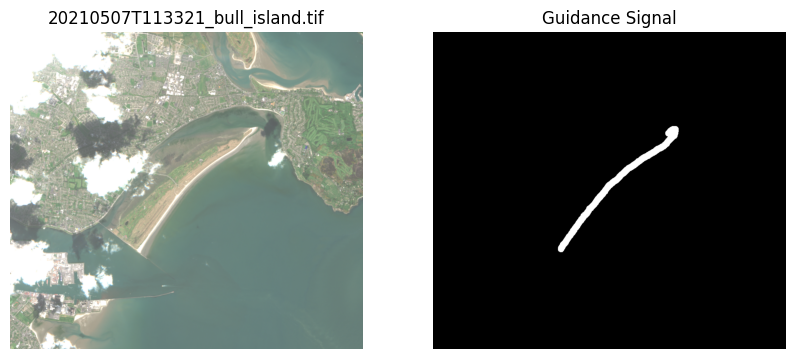

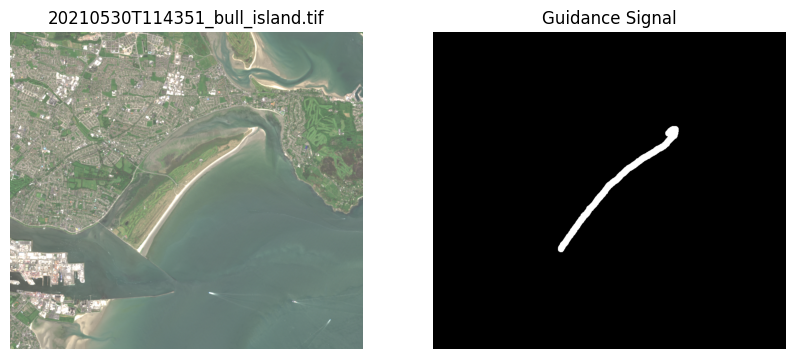

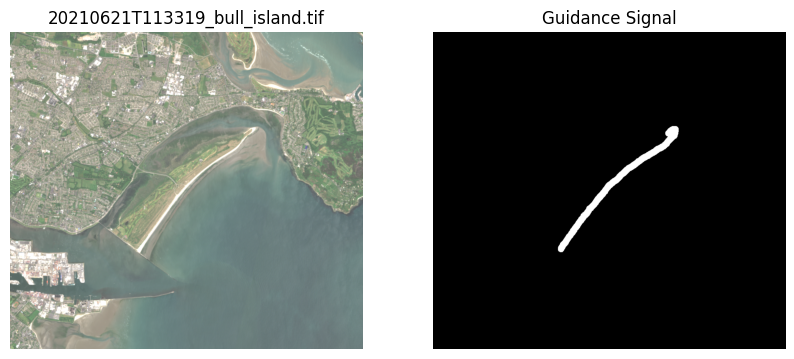

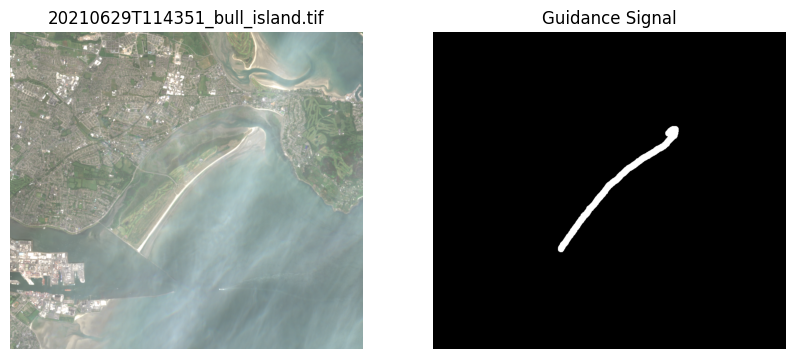

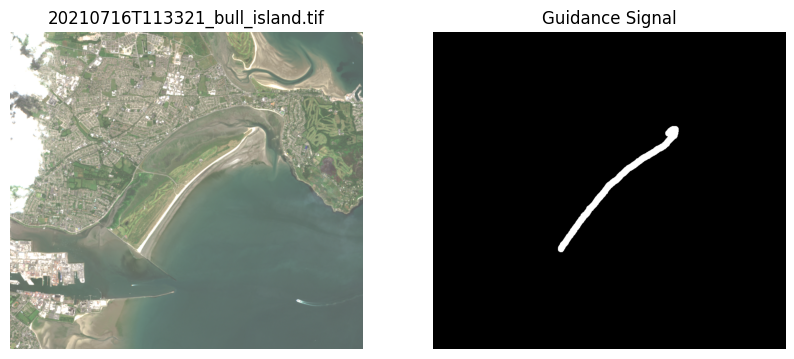

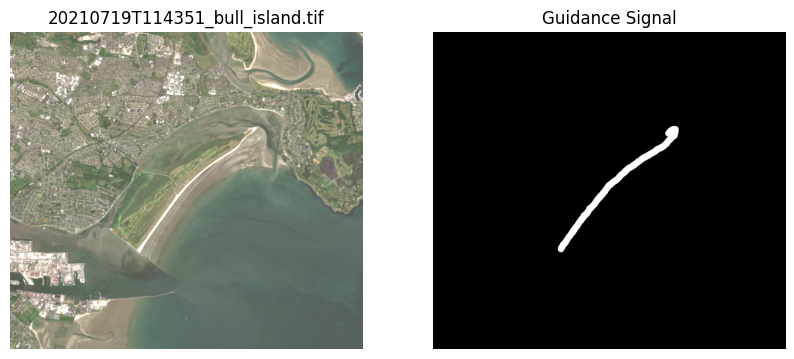

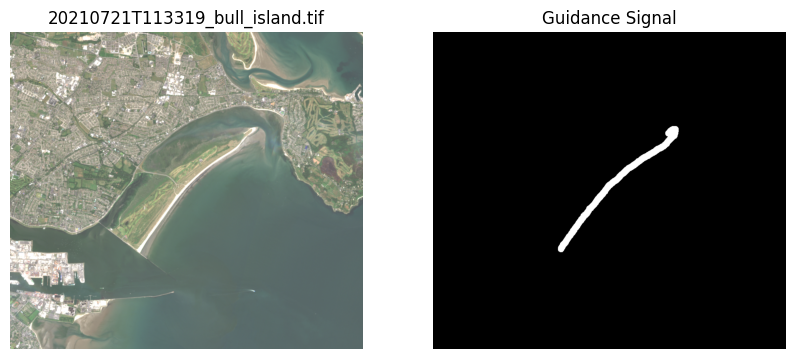

In [13]:
for i, file in enumerate(erosion_files):

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
   
    src = rasterio.open(file)
    band1 = src.read(1)
    band2 = src.read(2)
    band3 = src.read(3)

    guidance = src.read(5)

    image = np.dstack((band1, band2, band3))
    rgb_image = utils.get_rgb(image, r=0,g=1,b=2, contrast=0.3)

    ax[0].imshow(rgb_image)
    ax[0].set_title(os.path.basename(file))
    ax[0].axis('off')

    ax[1].imshow(guidance, cmap='gray')
    ax[1].set_title("Guidance Signal")
    ax[1].axis('off')